# 前回の復習・振り返り

相関係数のヒートマップ表示
```
plt.figure(figsize=(10,10))
sns.heatmap(df_one_hot.iloc[:,:20].corr(), cmap="coolwarm_r", vmin=-1, vmax=1, center=0)
```

数値が少ないクラスは、othersでまとめてしまう</br>
その上で2クラスのデータをone hotにしたら、各変数は必ず-1の相関がある</br>
可視化の方法は、y軸:目的変数、x軸:どれかの説明変数</br>
orderedな変数は、カテゴリカル変数にした方が良い、それ以外はone hot変数にした方が良い</br>
SVMとカーネルサイズを試す</br>

# Day2

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Model
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
# Data process
from sklearn.model_selection import KFold, train_test_split
# Metrics
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [3]:
# データの読み込み
df = pd.read_csv('./data/ks-projects-201801.csv')
print('Shape:', df.shape)
df.head()

Shape: (378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
# IDを除く
df = df.drop('ID', axis=1)
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# 目的変数の準備

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

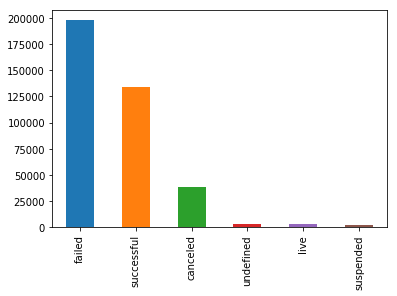

In [5]:
# stateの可視化
display(df.state.value_counts())
df.state.value_counts().plot.bar()

0    False
1    False
2    False
3    False
4    False
Name: state, dtype: bool

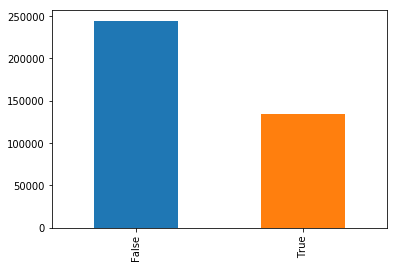

In [6]:
y_bool = df.state == 'successful'
display(y_bool.head())
y_bool.value_counts().plot.bar()

# 説明変数の準備

In [7]:
# 数字以外の抽出, nameはドロップ
x_obj_df = df.select_dtypes(include=['O']).drop(['name', 'state'], axis=1)
# 数字の抽出, 事前には知り得ない情報はドロップ
x_num_df = df.goal
x_num_df.head()

0     1000.0
1    30000.0
2    45000.0
3     5000.0
4    19500.0
Name: goal, dtype: float64

In [8]:
# 説明変数の結合
x_df = pd.concat([x_obj_df, x_num_df], axis=1)
x_df.head()

,category,main_category,currency,deadline,launched,country,goal
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,GB,1000.0
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,US,30000.0
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,US,45000.0
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,US,5000.0
4,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,US,19500.0


# 方針
- 日付は差分を取って数値データに
- カテゴリカル変数はデータ数の少ないものはothersにまとめて数値化
- その後one-hotベクトルに

### 日付データ

In [9]:
# 日付データに変更
df_date = pd.DataFrame()
for name in ['deadline', 'launched']:
    df_date[name] = pd.to_datetime(x_df[name])
df_date.head()

,deadline,launched
0,2015-10-09,2015-08-11 12:12:28
1,2017-11-01,2017-09-02 04:43:57
2,2013-02-26,2013-01-12 00:20:50
3,2012-04-16,2012-03-17 03:24:11
4,2015-08-29,2015-07-04 08:35:03


In [10]:
# 日付の差分を取る
df_days = df_date['deadline'] - df_date['launched']
df_days.name = 'days'
df_days.head()

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
4   55 days 15:24:57
Name: days, dtype: timedelta64[ns]

In [11]:
# 日数に変更
df_days = df_days.astype('timedelta64[D]')
df_days.head()

0    58.0
1    59.0
2    44.0
3    29.0
4    55.0
Name: days, dtype: float64

### カテゴリカルデータ
- まずはそれぞれをプロット<br>
category, main_category, currency, country

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Makerspaces            238
Printing               238
M

100

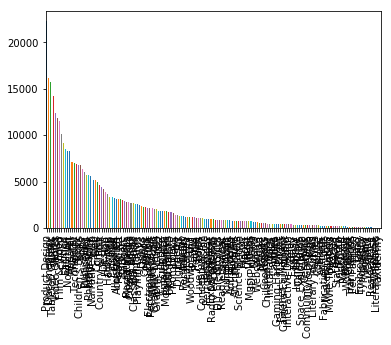

In [12]:
# category
display(x_df.category.value_counts())
display(x_df.category.value_counts()[151])
x_df.category.value_counts().plot.bar()

In [13]:
# 正規表現のシグマの値でしきい値を決める
# x_df.category.value_counts()

In [14]:
one_sigma = 159 * 0.6
display(int(one_sigma))
x_df.category.value_counts()[int(one_sigma)]

95

727

array(['Poetry', 'Narrative Film', 'Music', 'Film & Video', 'Restaurants',
       'Food', 'Drinks', 'Product Design', 'Documentary', 'Nonfiction',
       'Indie Rock', 'Crafts', 'Games', 'Tabletop Games', 'Design',
       'Comic Books', 'Art Books', 'Fashion', 'others', 'Theater',
       'Comics', 'DIY', 'Webseries', 'Animation', 'Food Trucks',
       'Public Art', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Fiction', 'Accessories', 'Rock', 'Hardware', 'Software',
       'Gadgets', 'Web', 'Jazz', 'Ready-to-wear', 'Festivals',
       'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Electronic Music', 'Radio & Podcasts', 'Apps', 'Apparel',
       'Comedy', 'Hip-Hop', 'Periodicals', 'Dance', 'Technology',
       'Painting', 'World Music', 'Photobooks', 'Drama', 'Architecture',
       'Young Adult', 'Mobile Games', 'Fine Art', 'Action',
       'Playing Cards', 'Thrillers', "Children's Books",
       'Performance Art', 'Graphic Novels', 'Performances', 'Sculp

(96,)

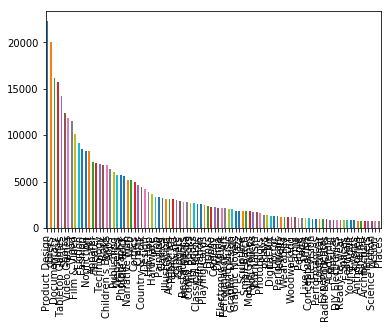

In [15]:
# しきい値より低い値を'others'にまとめる
cate_thread = x_df.category.value_counts()[int(one_sigma)] # = 2シグマ区間の151番目より小さい値をothersにまとめる
cate_dict = x_df.category.value_counts().to_dict()
cate_df = x_df.category.apply(lambda x: x if cate_dict[x] > cate_thread else 'others')
display(cate_df.unique())
display(cate_df.unique().shape)
cate_df.value_counts().plot.bar()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

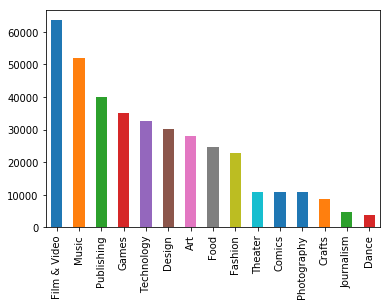

In [16]:
# main category
display(x_df.main_category.value_counts())
x_df.main_category.value_counts().plot.bar()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'others',
       'Games', 'Fashion', 'Art', 'Technology'], dtype=object)

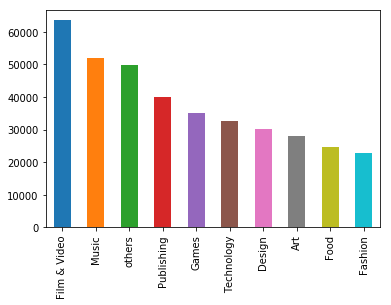

In [17]:
# しきい値より低い値を'others'にまとめる
main_cate_thread = 15000
main_cate_dict = x_df.main_category.value_counts().to_dict()
main_cate_df = x_df.main_category.apply(lambda x: x if main_cate_dict[x] > main_cate_thread else 'others')
display(main_cate_df.unique())
main_cate_df.value_counts().plot.bar()

USD    295365
GBP     34132
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64

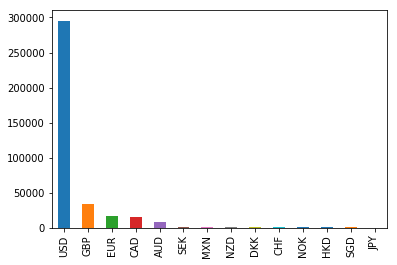

In [18]:
# currency
display(x_df.currency.value_counts())
x_df.currency.value_counts().plot.bar()

array(['GBP', 'USD', 'CAD', 'AUD', 'others', 'EUR'], dtype=object)

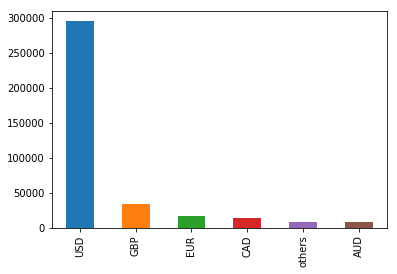

In [19]:
# しきい値より低い値を'others'にまとめる
currency_thread = 7000 # AUD以下
currency_dict = x_df.currency.value_counts().to_dict()
currency_df = x_df.currency.apply(lambda x: x if currency_dict[x] > currency_thread else 'others')
display(currency_df.unique())
currency_df.value_counts().plot.bar()

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

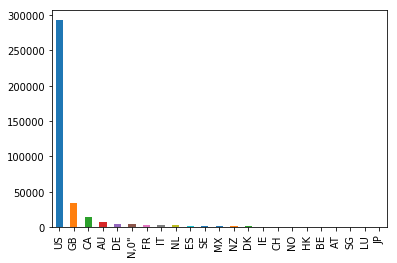

In [20]:
# country
display(x_df.country.value_counts())
x_df.country.value_counts().plot.bar()

array(['GB', 'US', 'CA', 'AU', 'others'], dtype=object)

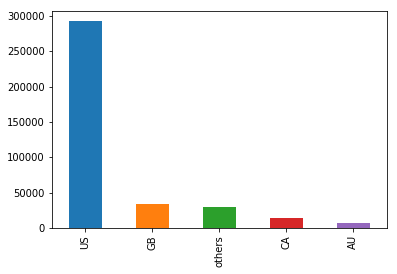

In [21]:
# しきい値より低い値を'others'にまとめる
country_thread = 7000 # AUD以下
country_dict = x_df.country.value_counts().to_dict()
country_df = x_df.country.apply(lambda x: x if country_dict[x] > country_thread else 'others')
display(country_df.unique())
country_df.value_counts().plot.bar()

In [22]:
# 全部をまとめる <category, main_category, currency, country>
x_df_cate_sum = pd.concat([cate_df, main_cate_df, currency_df, country_df], axis=1)
x_df_cate_sum.head()

,category,main_category,currency,country
0,Poetry,Publishing,GBP,GB
1,Narrative Film,Film & Video,USD,US
2,Narrative Film,Film & Video,USD,US
3,Music,Music,USD,US
4,Film & Video,Film & Video,USD,US


In [23]:
# objectをカテゴリカルに変換
x_df_cate_num = pd.DataFrame()
for column in x_df_cate_sum.columns:
    labels, uniques = pd.factorize(x_df_cate_sum[column])
    x_df_cate_num[column] = labels

In [24]:
x_df_cate_num.head()

,category,main_category,currency,country
0,0,0,0,0
1,1,1,1,1
2,1,1,1,1
3,2,2,1,1
4,3,1,1,1


# 説明変数と目的変数のscatterを表示

In [25]:
# 目的変数を0,1に変換
y_df_num = pd.Series(pd.factorize(y_bool)[0], name='state')
y_df_num.head()

0    0
1    0
2    0
3    0
4    0
Name: state, dtype: int64

In [26]:
# 結合
df_scatter = pd.concat([y_df_num, x_df_cate_num, x_df.goal], axis=1)
df_scatter.head()

,state,category,main_category,currency,country,goal
0,0,0,0,0,0,1000.0
1,0,1,1,1,1,30000.0
2,0,1,1,1,1,45000.0
3,0,2,2,1,1,5000.0
4,0,3,1,1,1,19500.0


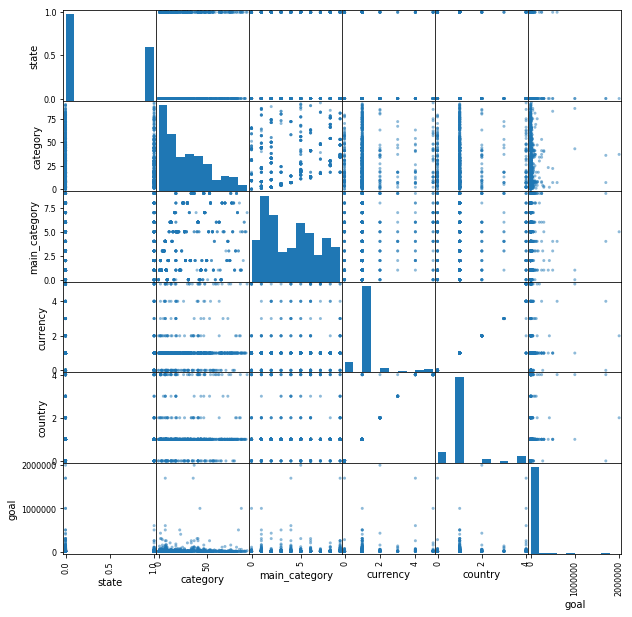

In [27]:
# 散布図を表示
pd.plotting.scatter_matrix(df_scatter.iloc[:1000, :], figsize=(10,10))
plt.show()

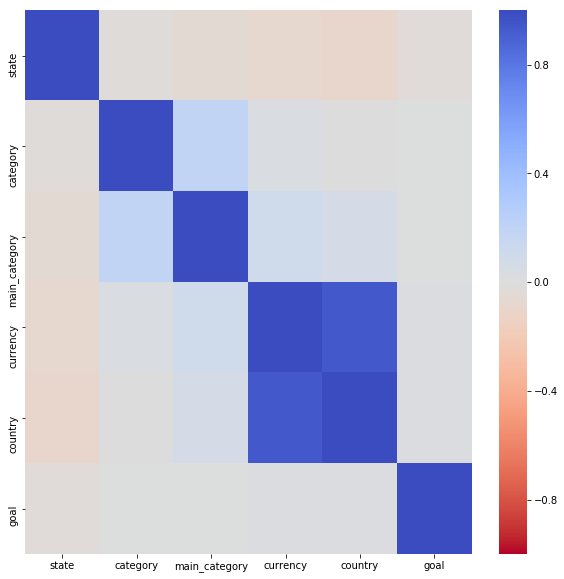

In [28]:
# 相関係数のヒートマップ表示
plt.figure(figsize=(10,10))
sns.heatmap(df_scatter.iloc[:,:].corr(), cmap="coolwarm_r", vmin=-1, vmax=1, center=0)

In [31]:
# カテゴリカルな説明変数をone hot に変換
x_df_one_hot = pd.get_dummies(x_df_cate_sum.iloc[:,:])
x_df_one_hot.head()

,category_Academic,category_Accessories,category_Action,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,...,currency_CAD,currency_EUR,currency_GBP,currency_USD,currency_others,country_AU,country_CA,country_GB,country_US,country_others
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [36]:
# 説明変数を結合 
# goalを入れると精度が下がる
x_df_sum = pd.concat([x_df_one_hot, df_days], axis=1)
display(x_df_sum.shape)
x_df_sum.head()

(378661, 118)

,category_Academic,category_Accessories,category_Action,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,...,currency_EUR,currency_GBP,currency_USD,currency_others,country_AU,country_CA,country_GB,country_US,country_others,days
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,58.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,59.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,44.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,29.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,55.0


# 学習の実行
- テストデータ、学習データに分割
- 学習データをクロスバリデーションでモデル評価
- テストデータで精度を見る

In [37]:
X = x_df_sum.values
y = y_bool.values * 1
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(302928, 118)

(75733, 118)

(302928,)

(75733,)

### SGDClassifier

## 各モデルを取り出す方法

In [38]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_log_like = 0
cross_valid_acc = 0
split_num = 1

# 検証役を交代させながら学習と評価を繰り返す
regr = []
# 配列の定義
y_pred_test = np.empty((len(X_test), n_split))

for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_split, random_state=None).split(X_train)):
    train_x, train_y = X_train[train_idx], y_train[train_idx] #学習用データ
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]     #検証用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr.append(SGDClassifier(loss='log', penalty='none', max_iter=100, fit_intercept=False))
    regr[i].fit(train_x, train_y)

    # 検証データに対する予測を実行
    y_pred_valid = regr[i].predict(valid_x)
    
    # 検証データに対する対数尤度を計算
    log_like = - log_loss(valid_y, y_pred_valid)
    acc = accuracy_score(valid_y, y_pred_valid)
    print("Fold %s"%split_num)
    print("対数尤度 = %s"%round(log_like, 3))
    print('正答率 = {:.3f}%'.format(100 * acc))
    print()
    
    cross_valid_log_like += log_like #後で平均を取るためにLog Likelihoodを加算
    cross_valid_acc += 100 * acc
    split_num += 1
    
    # テストデータの予測
    # 配列の列方向に予測結果を挿入していく
    y_pred_test[:,i] = regr[i].predict(X_test)
    # テストデータに対する対数尤度を計算
    test_log_like = - log_loss(y_test, y_pred_test[:,i])
    test_acc = accuracy_score(y_test, y_pred_test[:,i])
    print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
    print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))
    print()

# MAEの平均値を最終的な汎化誤差値とする
final_log_like = cross_valid_log_like / n_split
final_acc = cross_valid_acc / n_split
print("Cross Validation 対数尤度 = %s"%round(final_log_like, 3))
print("Cross Validation 正答率 = %s"%round(final_acc, 3))

# テスト
y_pred_test.shape

Fold 1
対数尤度 = -11.3
正答率 = 67.285%

テスト: 対数尤度 = -11.107
テスト: 正答率 = 67.842%

Fold 2
対数尤度 = -13.737
正答率 = 60.227%

テスト: 対数尤度 = -13.649
テスト: 正答率 = 60.484%

Fold 3
対数尤度 = -11.229
正答率 = 67.488%

テスト: 対数尤度 = -11.214
テスト: 正答率 = 67.533%

Fold 4
対数尤度 = -10.942
正答率 = 68.319%

テスト: 対数尤度 = -10.909
テスト: 正答率 = 68.417%

Fold 5
対数尤度 = -11.353
正答率 = 67.129%

テスト: 対数尤度 = -11.359
テスト: 正答率 = 67.112%

Cross Validation 対数尤度 = -11.712
Cross Validation 正答率 = 66.089


(75733, 5)

### KFold後のそれぞれのfoldでの結果を総合して計算

In [39]:
# 予測結果から合計して3以上を1,else 0→精度を再算出
y_pred_test_sum = (y_pred_test.sum(axis=1) > 3) * 1
display(y_pred_test_sum.shape)
# テストデータに対する対数尤度を計算
test_log_like = - log_loss(y_test, y_pred_test_sum)
test_acc = accuracy_score(y_test, y_pred_test_sum)
print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))

(75733,)

テスト: 対数尤度 = -11.212
テスト: 正答率 = 67.539%


## 相関のなさそうなcategoryを抜いて学習してみる

In [46]:
# カテゴリカルな説明変数をone hot に変換
x_df_one_hot = pd.get_dummies(x_df_cate_sum.drop('category', axis=1).iloc[:,:])
x_df_one_hot.head()
# 説明変数を結合
x_df_sum = pd.concat([x_df_one_hot, df_days], axis=1)
display(x_df_sum.shape)
x_df_sum.head()

(378661, 22)

,main_category_Art,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Music,main_category_Publishing,main_category_Technology,main_category_others,...,currency_EUR,currency_GBP,currency_USD,currency_others,country_AU,country_CA,country_GB,country_US,country_others,days
0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,58.0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,59.0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,44.0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,29.0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,55.0


In [47]:
X = x_df_sum.values
y = y_bool.values * 1
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(302928, 22)

(75733, 22)

(302928,)

(75733,)

In [48]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_log_like = 0
cross_valid_acc = 0
split_num = 1

# 検証役を交代させながら学習と評価を繰り返す
regr = []
# 配列の定義
y_pred_test = np.empty((len(X_test), n_split))

for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_split, random_state=None).split(X_train)):
    train_x, train_y = X_train[train_idx], y_train[train_idx] #学習用データ
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]     #検証用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr.append(SGDClassifier(loss='log', penalty='none', max_iter=100, fit_intercept=False))
    regr[i].fit(train_x, train_y)

    # 検証データに対する予測を実行
    y_pred_valid = regr[i].predict(valid_x)
    
    # 検証データに対する対数尤度を計算
    log_like = - log_loss(valid_y, y_pred_valid)
    acc = accuracy_score(valid_y, y_pred_valid)
    print("Fold %s"%split_num)
    print("対数尤度 = %s"%round(log_like, 3))
    print('正答率 = {:.3f}%'.format(100 * acc))
    print()
    
    cross_valid_log_like += log_like #後で平均を取るためにLog Likelihoodを加算
    cross_valid_acc += 100 * acc
    split_num += 1
    
    # テストデータの予測
    # 配列の列方向に予測結果を挿入していく
    y_pred_test[:,i] = regr[i].predict(X_test)
    # テストデータに対する対数尤度を計算
    test_log_like = - log_loss(y_test, y_pred_test[:,i])
    test_acc = accuracy_score(y_test, y_pred_test[:,i])
    print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
    print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))
    print()

# MAEの平均値を最終的な汎化誤差値とする
final_log_like = cross_valid_log_like / n_split
final_acc = cross_valid_acc / n_split
print("Cross Validation 対数尤度 = %s"%round(final_log_like, 3))
print("Cross Validation 正答率 = %s"%round(final_acc, 3))

# テスト
y_pred_test.shape

Fold 1
対数尤度 = -11.969
正答率 = 65.347%

テスト: 対数尤度 = -11.81
テスト: 正答率 = 65.808%

Fold 2
対数尤度 = -12.073
正答率 = 65.045%

テスト: 対数尤度 = -11.96
テスト: 正答率 = 65.373%

Fold 3
対数尤度 = -12.048
正答率 = 65.117%

テスト: 対数尤度 = -12.017
テスト: 正答率 = 65.208%

Fold 4
対数尤度 = -12.112
正答率 = 64.934%

テスト: 対数尤度 = -12.036
テスト: 正答率 = 65.151%

Fold 5
対数尤度 = -12.05
正答率 = 65.112%

テスト: 対数尤度 = -12.099
テスト: 正答率 = 64.969%

Cross Validation 対数尤度 = -12.05
Cross Validation 正答率 = 65.111


(75733, 5)

In [49]:
# 予測結果から合計して3以上を1,else 0→精度を再算出
y_pred_test_sum = (y_pred_test.sum(axis=1) > 3) * 1
display(y_pred_test_sum.shape)
# テストデータに対する対数尤度を計算
test_log_like = - log_loss(y_test, y_pred_test_sum)
test_acc = accuracy_score(y_test, y_pred_test_sum)
print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))

(75733,)

テスト: 対数尤度 = -12.018
テスト: 正答率 = 65.205%


### ↑結果精度が落ちた

# one-hotベクトルに変換

In [55]:
# カテゴリカルな説明変数をone hot に変換
x_df_one_hot = pd.get_dummies(x_df_cate_sum.iloc[:,:])
x_df_one_hot.head()

,category_Academic,category_Accessories,category_Action,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,...,currency_CAD,currency_EUR,currency_GBP,currency_USD,currency_others,country_AU,country_CA,country_GB,country_US,country_others
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


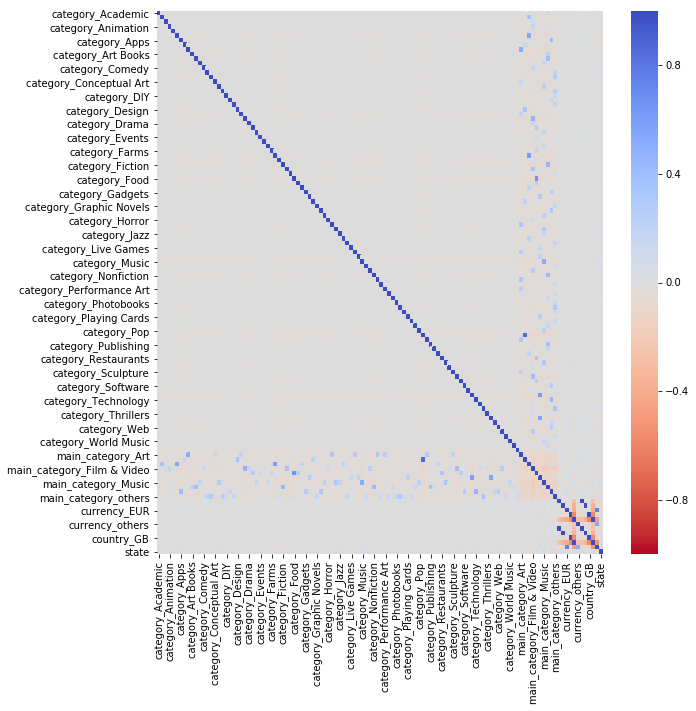

In [61]:
# 相関係数のヒートマップ表示
plt.figure(figsize=(10,10))
df_scatter_one_hot = pd.concat([x_df_one_hot, y_bool], axis=1)
sns.heatmap(df_scatter_one_hot.iloc[10000:,:].corr(), cmap="coolwarm_r", vmin=-1, vmax=1, center=0)

In [112]:
state_row = df_scatter_one_hot.iloc[10000:,:].corr()['state']
state_row.head()

category_Academic      -0.015762
category_Accessories   -0.002789
category_Action        -0.019199
category_Animation     -0.014664
category_Anthologies    0.029553
Name: state, dtype: float64

In [90]:
abs_state = state_row.apply(np.abs)
abs_state.head()

category_Academic       0.015762
category_Accessories    0.002789
category_Action         0.019199
category_Animation      0.014664
category_Anthologies    0.029553
Name: state, dtype: float64

In [105]:
# しきい値より低い値を'others'にまとめる
thread = 0.01 # AUD以下
state_abs_dict = abs_state.to_dict()
new_state_abs = abs_state.apply(lambda x: x if x > thread else None)
display(new_state_abs.unique())

array([0.01576155,        nan, 0.0191994 , 0.01466391, 0.02955334,
       0.04546681, 0.08037791, 0.01097068, 0.01707286, 0.02694295,
       0.04805659, 0.04169325, 0.035766  , 0.06343755, 0.0246147 ,
       0.02272389, 0.01071463, 0.05103067, 0.01004269, 0.01864653,
       0.01573271, 0.01657896, 0.0309641 , 0.01896443, 0.03584414,
       0.0170148 , 0.02479706, 0.03294866, 0.01379408, 0.02137214,
       0.02765154, 0.04262374, 0.03042875, 0.07292029, 0.0358459 ,
       0.01341676, 0.01178811, 0.01987035, 0.03853545, 0.02379673,
       0.01584578, 0.02664399, 0.01630154, 0.01249825, 0.02837013,
       0.01814355, 0.02828121, 0.02243769, 0.02786937, 0.02162951,
       0.01886934, 0.03502179, 0.04613419, 0.07162415, 0.04362915,
       0.08272178, 0.04706194, 0.02175074, 0.07820695, 0.05714877,
       0.06574732, 0.01538928, 0.01190223, 0.0131909 , 0.01398058,
       0.01867354, 0.03256177, 0.05751497, 0.01692862, 0.05904365,
       0.09340876, 0.03207885, 0.10042045, 0.05738236, 0.03064

In [115]:
new_label = set(new_state_abs.dropna().index)
list(new_label)

['category_Anthologies',
 'category_Architecture',
 'category_Animation',
 'category_Country & Folk',
 'category_Indie Rock',
 'category_Mobile Games',
 'category_Software',
 'currency_others',
 'category_Webseries',
 'main_category_Art',
 'category_Academic',
 'currency_AUD',
 'category_Fashion',
 'category_Festivals',
 'category_Comics',
 'main_category_Technology',
 'category_People',
 'category_Art Books',
 'category_Classical Music',
 'main_category_others',
 'category_Musical',
 'category_Performance Art',
 'category_Nonfiction',
 'category_Pop',
 'category_Apparel',
 'category_Games',
 'category_Theater',
 'category_Dance',
 'category_Young Adult',
 'country_AU',
 'category_Illustration',
 'main_category_Music',
 'category_Art',
 'main_category_Film & Video',
 'main_category_Fashion',
 'category_Film & Video',
 'category_Rock',
 'category_Events',
 'category_Graphic Novels',
 'category_Jewelry',
 'category_Public Art',
 'category_Web',
 'category_Farms',
 'category_Music',
 'cur

In [56]:
# 説明変数を結合
x_df_sum = pd.concat([x_df_one_hot, df_days], axis=1)
display(x_df_sum.shape)
x_df_sum.head()

(378661, 118)

,category_Academic,category_Accessories,category_Action,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,...,currency_EUR,currency_GBP,currency_USD,currency_others,country_AU,country_CA,country_GB,country_US,country_others,days
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,58.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,59.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,44.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,29.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,55.0


In [119]:
new_label_df = x_df_sum.loc[:, list(new_label)]
new_label_df.head()

/Users/yamaokadaichi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/Users/yamaokadaichi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,category_Anthologies,category_Architecture,category_Animation,category_Country & Folk,category_Indie Rock,category_Mobile Games,category_Software,currency_others,category_Webseries,main_category_Art,...,category_World Music,country_CA,category_Drinks,category_Restaurants,category_Publishing,category_Jazz,category_Comic Books,category_Food Trucks,category_DIY Electronics,category_Digital Art
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## one-hotのカラムを減らした上で評価

In [120]:
# 説明変数を結合
x_df_sum = pd.concat([x_df_one_hot, df_days], axis=1)
display(x_df_sum.shape)
x_df_sum.head()

(378661, 84)

,category_Anthologies,category_Architecture,category_Animation,category_Country & Folk,category_Indie Rock,category_Mobile Games,category_Software,currency_others,category_Webseries,main_category_Art,...,country_CA,category_Drinks,category_Restaurants,category_Publishing,category_Jazz,category_Comic Books,category_Food Trucks,category_DIY Electronics,category_Digital Art,days
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,59.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,55.0


In [175]:
X = x_df_sum.fillna(0).values # 欠損値があった
y = y_bool.values * 1
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(302928, 84)

(75733, 84)

(302928,)

(75733,)

In [176]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_log_like = 0
cross_valid_acc = 0
split_num = 1

# 検証役を交代させながら学習と評価を繰り返す
regr = []
# 配列の定義
y_pred_test = np.empty((len(X_test), n_split))

for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_split, random_state=None).split(X_train)):
    train_x, train_y = X_train[train_idx], y_train[train_idx] #学習用データ
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]     #検証用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr.append(SGDClassifier(loss='log', penalty='none', max_iter=100, fit_intercept=False))
    regr[i].fit(train_x, train_y)

    # 検証データに対する予測を実行
    y_pred_valid = regr[i].predict(valid_x)
    
    # 検証データに対する対数尤度を計算
    log_like = - log_loss(valid_y, y_pred_valid)
    acc = accuracy_score(valid_y, y_pred_valid)
    print("Fold %s"%split_num)
    print("対数尤度 = %s"%round(log_like, 3))
    print('正答率 = {:.3f}%'.format(100 * acc))
    print()
    
    cross_valid_log_like += log_like #後で平均を取るためにLog Likelihoodを加算
    cross_valid_acc += 100 * acc
    split_num += 1
    
    # テストデータの予測
    # 配列の列方向に予測結果を挿入していく
    y_pred_test[:,i] = regr[i].predict(X_test)
    # テストデータに対する対数尤度を計算
    test_log_like = - log_loss(y_test, y_pred_test[:,i])
    test_acc = accuracy_score(y_test, y_pred_test[:,i])
    print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
    print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))
    print()

# MAEの平均値を最終的な汎化誤差値とする
final_log_like = cross_valid_log_like / n_split
final_acc = cross_valid_acc / n_split
print("Cross Validation 対数尤度 = %s"%round(final_log_like, 3))
print("Cross Validation 正答率 = %s"%round(final_acc, 3))

# テスト
y_pred_test.shape

Fold 1
対数尤度 = -11.775
正答率 = 65.908%

テスト: 対数尤度 = -11.667
テスト: 正答率 = 66.219%

Fold 2
対数尤度 = -11.399
正答率 = 66.997%

テスト: 対数尤度 = -11.271
テスト: 正答率 = 67.368%

Fold 3
対数尤度 = -11.144
正答率 = 67.735%

テスト: 対数尤度 = -11.07
テスト: 正答率 = 67.951%

Fold 4
対数尤度 = -11.01
正答率 = 68.122%

テスト: 対数尤度 = -10.942
テスト: 正答率 = 68.319%

Fold 5
対数尤度 = -11.197
正答率 = 67.583%

テスト: 対数尤度 = -11.112
テスト: 正答率 = 67.828%

Cross Validation 対数尤度 = -11.305
Cross Validation 正答率 = 67.269


(75733, 5)

### KFold後のそれぞれのfoldでの結果を総合して計算

In [177]:
# 予測結果から合計して3以上を1,else 0→精度を再算出
y_pred_test_sum = (y_pred_test.sum(axis=1) > 3) * 1
display(y_pred_test_sum.shape)
# テストデータに対する対数尤度を計算
test_log_like = - log_loss(y_test, y_pred_test_sum)
test_acc = accuracy_score(y_test, y_pred_test_sum)
print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))

(75733,)

テスト: 対数尤度 = -11.272
テスト: 正答率 = 67.364%


# SVMClassifier

In [182]:
# 説明変数を結合
x_df_sum = pd.concat([x_df_one_hot, df_days], axis=1)
display(x_df_sum.shape)
x_df_sum.head()

(378661, 118)

,category_Academic,category_Accessories,category_Action,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,...,currency_EUR,currency_GBP,currency_USD,currency_others,country_AU,country_CA,country_GB,country_US,country_others,days
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,58.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,59.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,44.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,29.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,55.0


In [183]:
sample_size = 100000
X = x_df_sum.iloc[:sample_size,:].values
y = y_bool[:sample_size].values * 1
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80000, 118)

(20000, 118)

(80000,)

(20000,)

In [ ]:
n_split = 5 # グループ数を設定（今回は5分割）
C = 5
kernel = "rbf"
gamma = 1

cross_valid_log_like = 0
cross_valid_acc = 0
split_num = 1

# 検証役を交代させながら学習と評価を繰り返す
regr = []
# 配列の定義
y_pred_test = np.empty((len(X_test), n_split))

for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_split, random_state=None).split(X_train)):
    train_x, train_y = X_train[train_idx], y_train[train_idx] #学習用データ
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]     #検証用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr.append(SVC(C=C, kernel=kernel, gamma=gamma))
    regr[i].fit(train_x, train_y)

    # 検証データに対する予測を実行
    y_pred_valid = regr[i].predict(valid_x)
    
    # 検証データに対する対数尤度を計算
    log_like = - log_loss(valid_y, y_pred_valid)
    acc = accuracy_score(valid_y, y_pred_valid)
    print("Fold %s"%split_num)
    print("対数尤度 = %s"%round(log_like, 3))
    print('正答率 = {:.3f}%'.format(100 * acc))
    print()
    
    cross_valid_log_like += log_like #後で平均を取るためにLog Likelihoodを加算
    cross_valid_acc += 100 * acc
    split_num += 1
    
    # テストデータの予測
    # 配列の列方向に予測結果を挿入していく
    y_pred_test[:,i] = regr[i].predict(X_test)
    # テストデータに対する対数尤度を計算
    test_log_like = - log_loss(y_test, y_pred_test[:,i])
    test_acc = accuracy_score(y_test, y_pred_test[:,i])
    print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
    print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))
    print()

# MAEの平均値を最終的な汎化誤差値とする
final_log_like = cross_valid_log_like / n_split
final_acc = cross_valid_acc / n_split
print("Cross Validation 対数尤度 = %s"%round(final_log_like, 3))
print("Cross Validation 正答率 = %s"%round(final_acc, 3))

# テスト
y_pred_test.shape

Fold 1
対数尤度 = -11.312
正答率 = 67.250%



### SVMの総合結果

In [44]:
# 予測結果から合計して3以上を1,else 0→精度を再算出
y_pred_test_sum = (y_pred_test.sum(axis=1) > 3) * 1
display(y_pred_test_sum.shape)
# テストデータに対する対数尤度を計算
test_log_like = - log_loss(y_test, y_pred_test_sum)
test_acc = accuracy_score(y_test, y_pred_test_sum)
print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))

(4000,)

テスト: 対数尤度 = -11.925
テスト: 正答率 = 65.475%


# 標準化、白色化
- goal, days を標準化

In [40]:
# 標準化
from sklearn.preprocessing import StandardScaler

In [47]:
stdsc = StandardScaler()
x_df_std = x_df_sum.drop('days', axis=1)
x_df_std['std_days'] = stdsc.fit_transform(x_df_sum['days'].values.reshape(-1,1))
x_df_std['std_goal'] = stdsc.fit_transform(x_df['goal'].values.reshape(-1,1))
x_df_std.head()

,category_Academic,category_Accessories,category_Action,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,...,currency_GBP,currency_USD,currency_others,country_AU,country_CA,country_GB,country_US,country_others,std_days,std_goal
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0.372011,-0.040630
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0.387183,-0.016124
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0.159597,-0.003448
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,-0.067989,-0.037250
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0.326493,-0.024997


In [50]:
X = x_df_std.values
y = y_bool.values * 1
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(302928, 119)

(75733, 119)

(302928,)

(75733,)

In [51]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_log_like = 0
cross_valid_acc = 0
split_num = 1

# 検証役を交代させながら学習と評価を繰り返す
regr = []
# 配列の定義
y_pred_test = np.empty((len(X_test), n_split))

for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_split, random_state=None).split(X_train)):
    train_x, train_y = X_train[train_idx], y_train[train_idx] #学習用データ
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]     #検証用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr.append(SGDClassifier(loss='log', penalty='none', max_iter=100, fit_intercept=False))
    regr[i].fit(train_x, train_y)

    # 検証データに対する予測を実行
    y_pred_valid = regr[i].predict(valid_x)
    
    # 検証データに対する対数尤度を計算
    log_like = - log_loss(valid_y, y_pred_valid)
    acc = accuracy_score(valid_y, y_pred_valid)
    print("Fold %s"%split_num)
    print("対数尤度 = %s"%round(log_like, 3))
    print('正答率 = {:.3f}%'.format(100 * acc))
    print()
    
    cross_valid_log_like += log_like #後で平均を取るためにLog Likelihoodを加算
    cross_valid_acc += 100 * acc
    split_num += 1
    
    # テストデータの予測
    # 配列の列方向に予測結果を挿入していく
    y_pred_test[:,i] = regr[i].predict(X_test)
    # テストデータに対する対数尤度を計算
    test_log_like = - log_loss(y_test, y_pred_test[:,i])
    test_acc = accuracy_score(y_test, y_pred_test[:,i])
    print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
    print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))
    print()

# MAEの平均値を最終的な汎化誤差値とする
final_log_like = cross_valid_log_like / n_split
final_acc = cross_valid_acc / n_split
print("Cross Validation 対数尤度 = %s"%round(final_log_like, 3))
print("Cross Validation 正答率 = %s"%round(final_acc, 3))

# テスト
y_pred_test.shape

Fold 1
対数尤度 = -10.879
正答率 = 68.501%

テスト: 対数尤度 = -10.635
テスト: 正答率 = 69.209%

Fold 2
対数尤度 = -10.78
正答率 = 68.788%

テスト: 対数尤度 = -10.64
テスト: 正答率 = 69.193%

Fold 3
対数尤度 = -10.722
正答率 = 68.958%

テスト: 対数尤度 = -10.624
テスト: 正答率 = 69.241%

Fold 4
対数尤度 = -10.662
正答率 = 69.129%

テスト: 対数尤度 = -10.613
テスト: 正答率 = 69.272%

Fold 5
対数尤度 = -10.732
正答率 = 68.928%

テスト: 対数尤度 = -10.622
テスト: 正答率 = 69.247%

Cross Validation 対数尤度 = -10.755
Cross Validation 正答率 = 68.861


(75733, 5)

### KFold後のそれぞれのfoldでの結果を総合して計算

In [52]:
# 予測結果から合計して3以上を1,else 0→精度を再算出
y_pred_test_sum = (y_pred_test.sum(axis=1) > 3) * 1
display(y_pred_test_sum.shape)
# テストデータに対する対数尤度を計算
test_log_like = - log_loss(y_test, y_pred_test_sum)
test_acc = accuracy_score(y_test, y_pred_test_sum)
print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))

(75733,)

テスト: 対数尤度 = -10.627
テスト: 正答率 = 69.233%


#### 標準化で精度が上がった

### 白色化

In [57]:
#  無相関化を行うための一連の処理
cov = np.cov(X, rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
X_decorr = np.dot(S.T, X.T).T #データを無相関化
X_decorr.shape

(378661, 119)

In [58]:
y = y_bool.values * 1
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X_decorr, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(302928, 119)

(75733, 119)

(302928,)

(75733,)

In [59]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_log_like = 0
cross_valid_acc = 0
split_num = 1

# 検証役を交代させながら学習と評価を繰り返す
regr = []
# 配列の定義
y_pred_test = np.empty((len(X_test), n_split))

for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_split, random_state=None).split(X_train)):
    train_x, train_y = X_train[train_idx], y_train[train_idx] #学習用データ
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]     #検証用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr.append(SGDClassifier(loss='log', penalty='none', max_iter=100, fit_intercept=False))
    regr[i].fit(train_x, train_y)

    # 検証データに対する予測を実行
    y_pred_valid = regr[i].predict(valid_x)
    
    # 検証データに対する対数尤度を計算
    log_like = - log_loss(valid_y, y_pred_valid)
    acc = accuracy_score(valid_y, y_pred_valid)
    print("Fold %s"%split_num)
    print("対数尤度 = %s"%round(log_like, 3))
    print('正答率 = {:.3f}%'.format(100 * acc))
    print()
    
    cross_valid_log_like += log_like #後で平均を取るためにLog Likelihoodを加算
    cross_valid_acc += 100 * acc
    split_num += 1
    
    # テストデータの予測
    # 配列の列方向に予測結果を挿入していく
    y_pred_test[:,i] = regr[i].predict(X_test)
    # テストデータに対する対数尤度を計算
    test_log_like = - log_loss(y_test, y_pred_test[:,i])
    test_acc = accuracy_score(y_test, y_pred_test[:,i])
    print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
    print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))
    print()

# MAEの平均値を最終的な汎化誤差値とする
final_log_like = cross_valid_log_like / n_split
final_acc = cross_valid_acc / n_split
print("Cross Validation 対数尤度 = %s"%round(final_log_like, 3))
print("Cross Validation 正答率 = %s"%round(final_acc, 3))

# テスト
y_pred_test.shape

Fold 1
対数尤度 = -10.858
正答率 = 68.562%

テスト: 対数尤度 = -10.614
テスト: 正答率 = 69.270%

Fold 2
対数尤度 = -10.798
正答率 = 68.737%

テスト: 対数尤度 = -10.644
テスト: 正答率 = 69.184%

Fold 3
対数尤度 = -10.719
正答率 = 68.965%

テスト: 対数尤度 = -10.634
テスト: 正答率 = 69.210%

Fold 4
対数尤度 = -10.674
正答率 = 69.095%

テスト: 対数尤度 = -10.619
テスト: 正答率 = 69.254%

Fold 5
対数尤度 = -10.737
正答率 = 68.915%

テスト: 対数尤度 = -10.633
テスト: 正答率 = 69.214%

Cross Validation 対数尤度 = -10.757
Cross Validation 正答率 = 68.855


(75733, 5)

### KFold後のそれぞれのfoldでの結果を総合して計算

In [60]:
# 予測結果から合計して3以上を1,else 0→精度を再算出
y_pred_test_sum = (y_pred_test.sum(axis=1) > 3) * 1
display(y_pred_test_sum.shape)
# テストデータに対する対数尤度を計算
test_log_like = - log_loss(y_test, y_pred_test_sum)
test_acc = accuracy_score(y_test, y_pred_test_sum)
print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))

(75733,)

テスト: 対数尤度 = -10.636
テスト: 正答率 = 69.206%


## SVM

In [62]:
sample_size = 10000
X = X_decorr[:sample_size]
y = y_bool[:sample_size].values * 1
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 119)

(2000, 119)

(8000,)

(2000,)

In [63]:
n_split = 5 # グループ数を設定（今回は5分割）
C = 5
kernel = "rbf"
gamma = 1

cross_valid_log_like = 0
cross_valid_acc = 0
split_num = 1

# 検証役を交代させながら学習と評価を繰り返す
regr = []
# 配列の定義
y_pred_test = np.empty((len(X_test), n_split))

for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_split, random_state=None).split(X_train)):
    train_x, train_y = X_train[train_idx], y_train[train_idx] #学習用データ
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]     #検証用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr.append(SVC(C=C, kernel=kernel, gamma=gamma))
    regr[i].fit(train_x, train_y)

    # 検証データに対する予測を実行
    y_pred_valid = regr[i].predict(valid_x)
    
    # 検証データに対する対数尤度を計算
    log_like = - log_loss(valid_y, y_pred_valid)
    acc = accuracy_score(valid_y, y_pred_valid)
    print("Fold %s"%split_num)
    print("対数尤度 = %s"%round(log_like, 3))
    print('正答率 = {:.3f}%'.format(100 * acc))
    print()
    
    cross_valid_log_like += log_like #後で平均を取るためにLog Likelihoodを加算
    cross_valid_acc += 100 * acc
    split_num += 1
    
    # テストデータの予測
    # 配列の列方向に予測結果を挿入していく
    y_pred_test[:,i] = regr[i].predict(X_test)
    # テストデータに対する対数尤度を計算
    test_log_like = - log_loss(y_test, y_pred_test[:,i])
    test_acc = accuracy_score(y_test, y_pred_test[:,i])
    print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
    print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))
    print()

# MAEの平均値を最終的な汎化誤差値とする
final_log_like = cross_valid_log_like / n_split
final_acc = cross_valid_acc / n_split
print("Cross Validation 対数尤度 = %s"%round(final_log_like, 3))
print("Cross Validation 正答率 = %s"%round(final_acc, 3))

# テスト
y_pred_test.shape

Fold 1
対数尤度 = -11.959
正答率 = 65.375%

テスト: 対数尤度 = -12.192
テスト: 正答率 = 64.700%

Fold 2
対数尤度 = -10.707
正答率 = 69.000%

テスト: 対数尤度 = -11.778
テスト: 正答率 = 65.900%

Fold 3
対数尤度 = -10.858
正答率 = 68.562%

テスト: 対数尤度 = -11.985
テスト: 正答率 = 65.300%

Fold 4
対数尤度 = -11.052
正答率 = 68.000%

テスト: 対数尤度 = -11.812
テスト: 正答率 = 65.800%

Fold 5
対数尤度 = -11.506
正答率 = 66.688%

テスト: 対数尤度 = -11.899
テスト: 正答率 = 65.550%

Cross Validation 対数尤度 = -11.217
Cross Validation 正答率 = 67.525


(2000, 5)

### SVMの総合結果

In [64]:
# 予測結果から合計して3以上を1,else 0→精度を再算出
y_pred_test_sum = (y_pred_test.sum(axis=1) > 3) * 1
display(y_pred_test_sum.shape)
# テストデータに対する対数尤度を計算
test_log_like = - log_loss(y_test, y_pred_test_sum)
test_acc = accuracy_score(y_test, y_pred_test_sum)
print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))

(2000,)

テスト: 対数尤度 = -11.864
テスト: 正答率 = 65.650%
